<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/BERT_esm1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studying ProstT5's potential use of evolutionary information

In [1]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/algosb_2021/main/utils.py
import torch 
import matplotlib.pyplot as plt
import numpy as np
from utils import *

In [4]:
alphabet_len = 33
alphabet= 'LAGVSERTIDPKQNFYMHWC-'

LAGVSERTIDPKQNFYMHWC-
33


### Build the MSA

In [7]:
headers, seqs = parse_fasta("RL29.uni.1e-10.i8.i90c75.a3m", a3m = True)
msa = mk_msa(seqs, alphabet=alphabet)
seq = seqs[0] 
print(msa.shape)
print(seq)

(11367, 63, 21)
MKAKELREKSVEELNTELLNLLREQFNLRMQAASGQLQQSHLLKQVRRDVARVKTLLNEKAGA


### Load embedding of the translated sequence

In [8]:
import pickle

def get_logits_from_embed(embed):
  return embed[0].cpu().detach().numpy().T[:-1]

with open(
    "predictions_cpu.pickle", "rb"
) as embeddings:
    embeds = pickle.load(embeddings)

[[ -1.601   -0.838    7.97   ...   0.9907  -7.13     0.2625]
 [  0.84    -2.863    4.79   ...  -0.1819  -4.94    -1.632 ]
 [ -2.613   -0.752   -0.1294 ...   0.7534  -6.773   -7.68  ]
 ...
 [ -7.56    -0.927   -1.814  ...   7.18   -10.76   -10.4   ]
 [ -5.59    -2.084    0.1959 ...   4.41    -8.695   -6.75  ]
 [ -4.938   -0.912    0.8125 ...   3.17    -7.617   -5.312 ]]
63
20


### Load embeddings of all mutated sequences 

In [11]:
with open(
    "predictions_mutated_cpu.pickle", "rb"
) as embeddings_mutated:
    embeds_mutated = pickle.load(embeddings_mutated)
for i in range(len(embeds_mutated)):
    embeds_mutated[i]=embeds_mutated[i][0].T[:-1]
print(len(embeds_mutated[0]))
print(len(embeds_mutated[0][0]))
embeds_grouped=[torch.stack(embeds_mutated[i:i+20]) for i in range(0, len(embeds_mutated),20)]
stacked_embeds=torch.stack(embeds_grouped)
print(stacked_embeds.shape)

1260
63
20
torch.Size([63, 20, 63, 20])


### Build the Categorical Jacobian

In [9]:
def get_categorical_jacobian_from_embeds(embed):
  ln=len(embed)
  embed=torch.Tensor(embed)
  with torch.no_grad():
    fx=torch.stack([torch.stack([embed for i in range(20)]) for j in range(ln)]).cpu().numpy()
    print(fx.shape)
    fx_h = stacked_embeds.cpu().numpy()
    return fx_h - fx

In [12]:
jac_from_embeds=get_categorical_jacobian_from_embeds(get_logits_from_embed(embeds[0]))
print(jac_from_embeds.shape)

for i in range(4): jac_from_embeds -= jac_from_embeds.mean(i,keepdims=True)
jac_from_embeds = (jac_from_embeds + jac_from_embeds.transpose(2,3,0,1))/2
print(jac_from_embeds.shape)

(63, 20, 63, 20)
(63, 20, 63, 20)
(63, 20, 63, 20)


### Predict contacts from the MSA

In [18]:
tmp = inv_cov_jax(msa)
L = len(seq)
ic = tmp["ic"].reshape(L,21,L,21)[:,:20,:,:20]
ic.shape

(63, 20, 63, 20)

### Visualize the contact maps predicted from the MSA and from the Categorical Jacobian

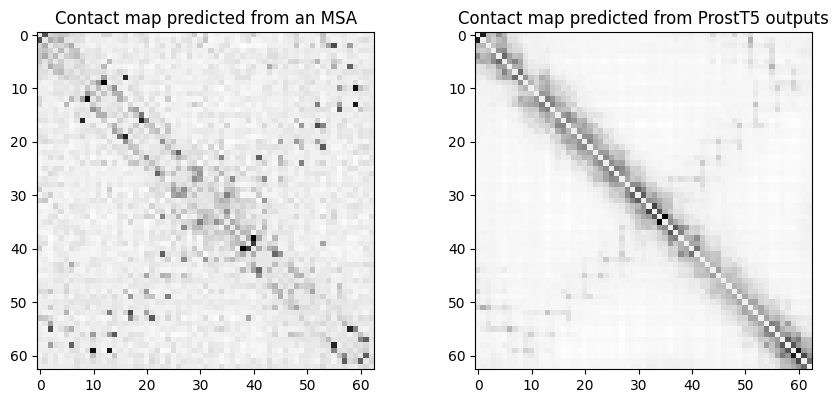

In [19]:
import seaborn as sns
fig, axs=plt.subplots(1,2,figsize=(10,5))
sns.set_style('ticks')
axs[0].imshow(tmp["apc"], cmap="Greys")
axs[0].set_title("Contact map predicted from an MSA")
axs[1].imshow(get_contacts(jac_from_embeds), cmap="Greys")
axs[1].set_title("Contact map predicted from ProstT5 outputs")

plt.subplots_adjust(wspace=0.3)
fig.show()

fig.savefig('Contact_maps.pdf', bbox_inches='tight', pad_inches=0.3, dpi=500)

### Compute identity percentages between predicted 3Di sequences and profiles 

In [23]:
def read_substitution_matrix(matrix_str):
    # Split the string into lines
    lines = matrix_str.strip().split("\n")
    
    lines = lines[3:]
    
    # Extract the header (amino acids)
    header = lines[0].split()
    
    # Initialize the substitution matrix dictionary
    subMat = {}
    
    # Process each line after the header
    for line in lines[1:]:
        parts = line.split()
        row_letter = parts[0]
        scores = parts[1:]
        
        # Ensure the row exists in the dictionary
        subMat[row_letter] = {}
        
        # Populate the row with scores
        for col_letter, score in zip(header, scores):
            subMat[row_letter][col_letter] = int(score)
    
    return subMat


def id_percentage(str1, str2):
    if len(str1) != len(str2):
        str1=str1[:min(len(str1),len(str2))]
        str2=str2[:min(len(str1),len(str2))]
    matches = float(sum(c1 == c2 for c1, c2 in zip(str1, str2)))
    
    identity = float((matches / len(str1))) * 100.0

    return identity

with open('mat3di.out') as fh:
    content = fh.read()
    subMat = read_substitution_matrix(content)
    

identity_percentage = id_percentage

id=''
fs_seqs={}
lens=[]
with open("scopefs3di.fasta", 'r') as fs:
    for line in fs:
        if line[0]=='>':
            id=line.strip()
        else:
            fs_seqs[id]=line.strip()
            lens.append(len(line.strip())) 
           
prostT5_seqs={}
with open("scope_3di.fasta", 'r') as pt5:
    for line in pt5:
        if line[0]=='>':
            id=line.strip()
        else:
            prostT5_seqs[id]=line.strip()
            
fs_profile_seqs={}
with open("scopeConsensus.fasta", 'r') as prof:
    for line in prof:
        if line[0]=='>':
            id=line.strip()
        else:
            fs_profile_seqs[id]=line.strip()
            
pt5_profile_seqs={}
with open("pt5scopeProfiles.fasta", 'r') as prof:
    for line in prof:
        if line[0]=='>':
            id=line.strip()
        else:
            pt5_profile_seqs[id]=line.strip()
fs_percentage=[]
pt5_percentage=[]

sum_seq=0

for id in fs_seqs:
    fs_percentage.append(id_percentage(fs_seqs[id], fs_profile_seqs[id]))
    pt5_percentage.append(id_percentage(prostT5_seqs[id], pt5_profile_seqs[id]))
    
fs_percentage_sorted=sorted(fs_percentage)
pt5_percentage_sorted=sorted(pt5_percentage)
percentages=[0.1*i for i in range(1000)]
cnt1=0
cnt2=0
fs=[]
pt5=[]

for i in range(1000):
    while(fs_percentage_sorted[cnt1]<percentages[i]):
        cnt1+=1
    while(pt5_percentage_sorted[cnt2]<percentages[i]):
        cnt2+=1
    fs.append(1-(cnt1/len(fs_percentage_sorted)))
    pt5.append(1-(cnt2/len(pt5_percentage_sorted)))

### Visualize identity percentages 

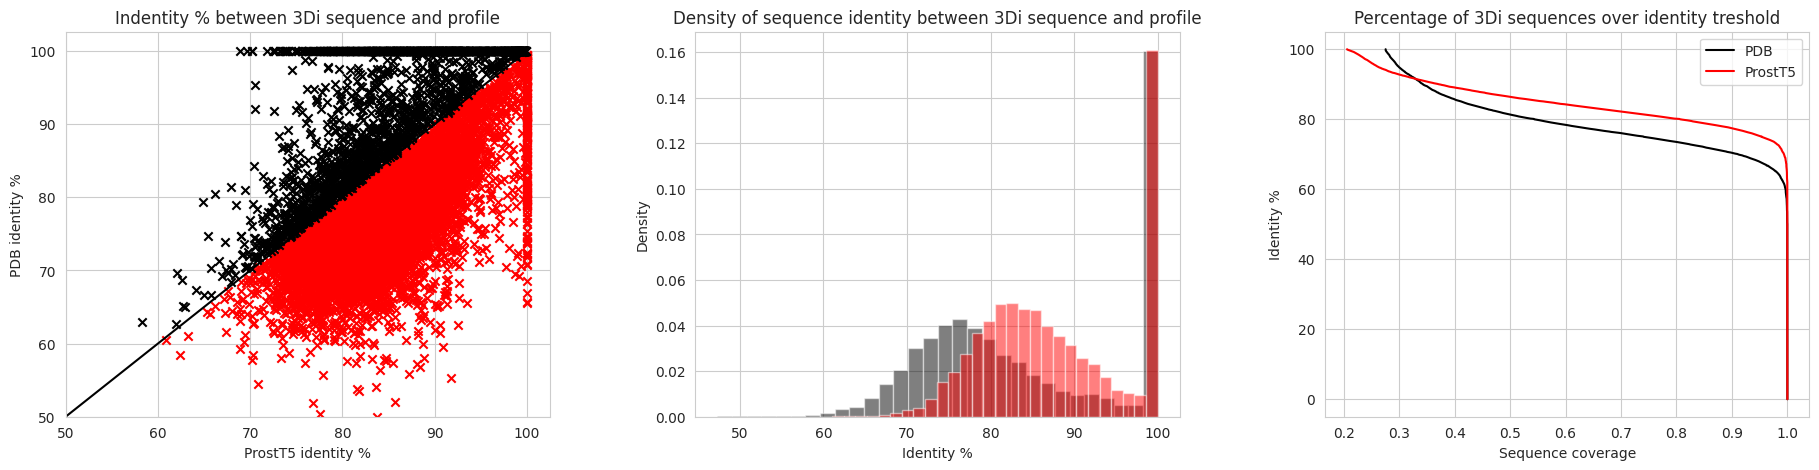

In [24]:
import seaborn as sns
plt.rcParams.update({'font.size': 10})
sns.set_style('whitegrid')
fig, axs=plt.subplots(1,3,figsize=(22.5,5))
pt5_better_pt5=[]
pt5_better_fs=[]
fs_better_pt5=[]
fs_better_fs=[]
for i in range(len(fs_percentage)):
    if fs_percentage[i] > pt5_percentage[i]:
        fs_better_pt5.append(pt5_percentage[i])
        fs_better_fs.append(fs_percentage[i])
    elif fs_percentage[i] < pt5_percentage[i] :
        pt5_better_pt5.append(pt5_percentage[i])
        pt5_better_fs.append(fs_percentage[i])
axs[0].scatter(pt5_better_pt5, pt5_better_fs, color='red', marker='x')
axs[0].scatter(fs_better_pt5, fs_better_fs, color='black', marker='x')
axs[0].plot([50,100], [50,100], color='black')
axs[0].set_xlim(left=50)
axs[0].set_ylim(bottom=50)
axs[0].set_title('Indentity % between 3Di sequence and profile')
axs[0].set_xlabel('ProstT5 identity %')
axs[0].set_ylabel('PDB identity %')

axs[1].hist(fs_percentage, bins=30, label='PDB', alpha=0.5, density=True, color='black')
axs[1].hist(pt5_percentage, bins=30, label='ProstT5', alpha=0.5, density=True, color='red')
axs[1].set_title('Density of sequence identity between 3Di sequence and profile')
axs[1].set_ylabel('Density')
axs[1].set_xlabel('Identity %')
#axs[1].legend()

axs[2].plot(fs, percentages, label='PDB', color='black')
axs[2].plot(pt5, percentages, label='ProstT5', color='red')
axs[2].legend()
axs[2].set_ylabel('Identity %')
axs[2].set_xlabel('Sequence coverage')
axs[2].set_title('Percentage of 3Di sequences over identity treshold')

plt.subplots_adjust(wspace=0.3)

fig.savefig("Identity_percentage_visualization.svg", bbox_inches='tight', dpi=500, pad_inches=0.3)